<a href="https://colab.research.google.com/github/NimZii/Stock-Price-Prediction-RNN/blob/main/StockPrice_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**This code implement a simple RNN model to take a series of a price for a stock in the market as input, and based on the prices of previous 25 days, predict the stock value of the next day**

In [ ]:
import tensorflow
import keras
import sklearn

In [ ]:
# Here we load and show head of the data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Input the csv file which has the prices of each day under the column of "price"

prices = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/FB-stock-prices.csv")

print(prices.dtypes)
prices.head()

Date     object
Price     int64
dtype: object


,Date,Price
0,1/4/2021,269
1,1/5/2021,271
2,1/6/2021,263
3,1/7/2021,269
4,1/8/2021,268


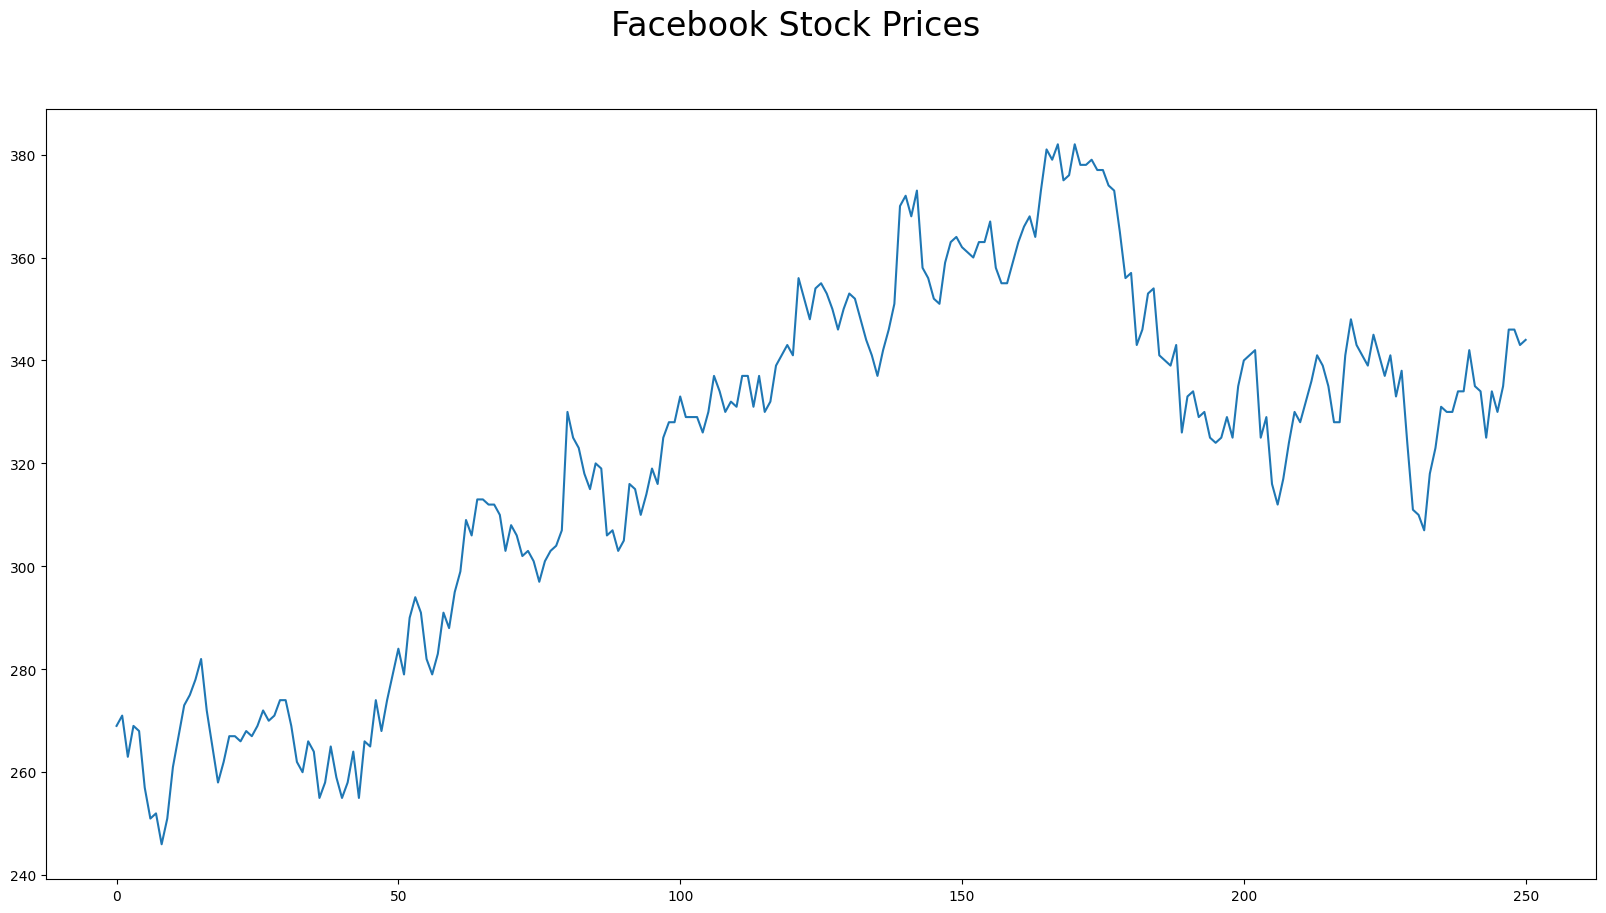

In [ ]:
# Visualize the stock price

plt.figure(figsize=(20,10)).suptitle("Facebook Stock Prices", fontsize=24)
plt.plot(prices['Price'])
plt.show()

# Preprocess Data

In [ ]:
# Preprocess data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_price = scaler.fit_transform(prices[['Price']].values)

# Split data into training and test sets
total_size = len(scaled_price)

# Test size
test_size = 50

# Training size
train_size = total_size - test_size
print(train_size, test_size)

training_prices = scaled_price[0:train_size,:]
test_prices = scaled_price[train_size:,:]

print(training_prices.shape,test_prices.shape)

201 50
(201, 1) (50, 1)


# Creating Data set for RNN

In [ ]:
# Create dataset for RNN
# Each data point (X) is linked to the previous data points of size = lookback
# The predicted value (Y) is the next point

def create_rnn_dataset(data, lookback=1):

    data_x, data_y = [], []
    for i in range(len(data) - lookback - 1):
        # Data points
        a = data[i:i+lookback,0]
        data_x.append(a)
        # Expected values
        data_y.append(data[i+lookback])
    return np.array(data_x), np.array(data_y)

# set lookback
lookback = 25

# giving the values to the function
train_req_x, train_req_y = create_rnn_dataset(training_prices, lookback)

# reshape for use with RNN
train_req_x = np.reshape(train_req_x,
                         (train_req_x.shape[0], 1, train_req_x.shape[1]))

print("Shapes of X, Y: ", train_req_x.shape, train_req_y.shape)

Shapes of X, Y:  (175, 1, 25) (175, 1)


# Build The RNN Model

In [ ]:
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
import tensorflow as tf

tf.random.set_seed(2)

# Create a sequential model
price_model = Sequential()
# Add a simple RNN layer with 32 nodes
price_model.add(SimpleRNN(32, input_shape=(1, lookback)))
# Add a Dense layer at the end for output
price_model.add(Dense(1))

# Compile the model
price_model.compile(loss='mean_squared_error', optimizer='adam',metrics=['mse'])

# Summary
price_model.summary()

# Train
price_model.fit(train_req_x, train_req_y, epochs=5, batch_size=1, verbose=1)

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_9 (SimpleRNN)    (None, 32)                1856      
                                                                 
 dense_9 (Dense)             (None, 1)                 33        
                                                                 
Total params: 1889 (7.38 KB)
Trainable params: 1889 (7.38 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
175/175 [==============================] - 1s 2ms/step - loss: 0.5228 - mse: 0.5228
Epoch 2/5
175/175 [==============================] - 0s 2ms/step - loss: 0.0835 - mse: 0.0835
Epoch 3/5
175/175 [==============================] - 1s 4ms/step - loss: 0.0584 - mse: 0.0584
Epoch 4/5
175/175 [==============================] - 1s 4ms/step - loss: 0.0514 - mse: 0.0514
Epoch 5/5
175/175 [======================

# Testing Model

In [ ]:
test_req_x, test_req_y = create_rnn_dataset(test_prices, lookback)

test_req_x = np.reshape(test_req_x,
                        (test_req_x.shape[0], 1, test_req_x.shape[1]))
print(test_req_x.shape)
price_model.evaluate(test_req_x, test_req_y, verbose=1)

# predict on test data
predict_on_test = price_model.predict(test_req_x)

# inverse transform to viualize
predict_on_test = scaler.inverse_transform(predict_on_test)

(24, 1, 25)
1/1 [==============================] - 0s 30ms/step


# Visualize data to see model performance

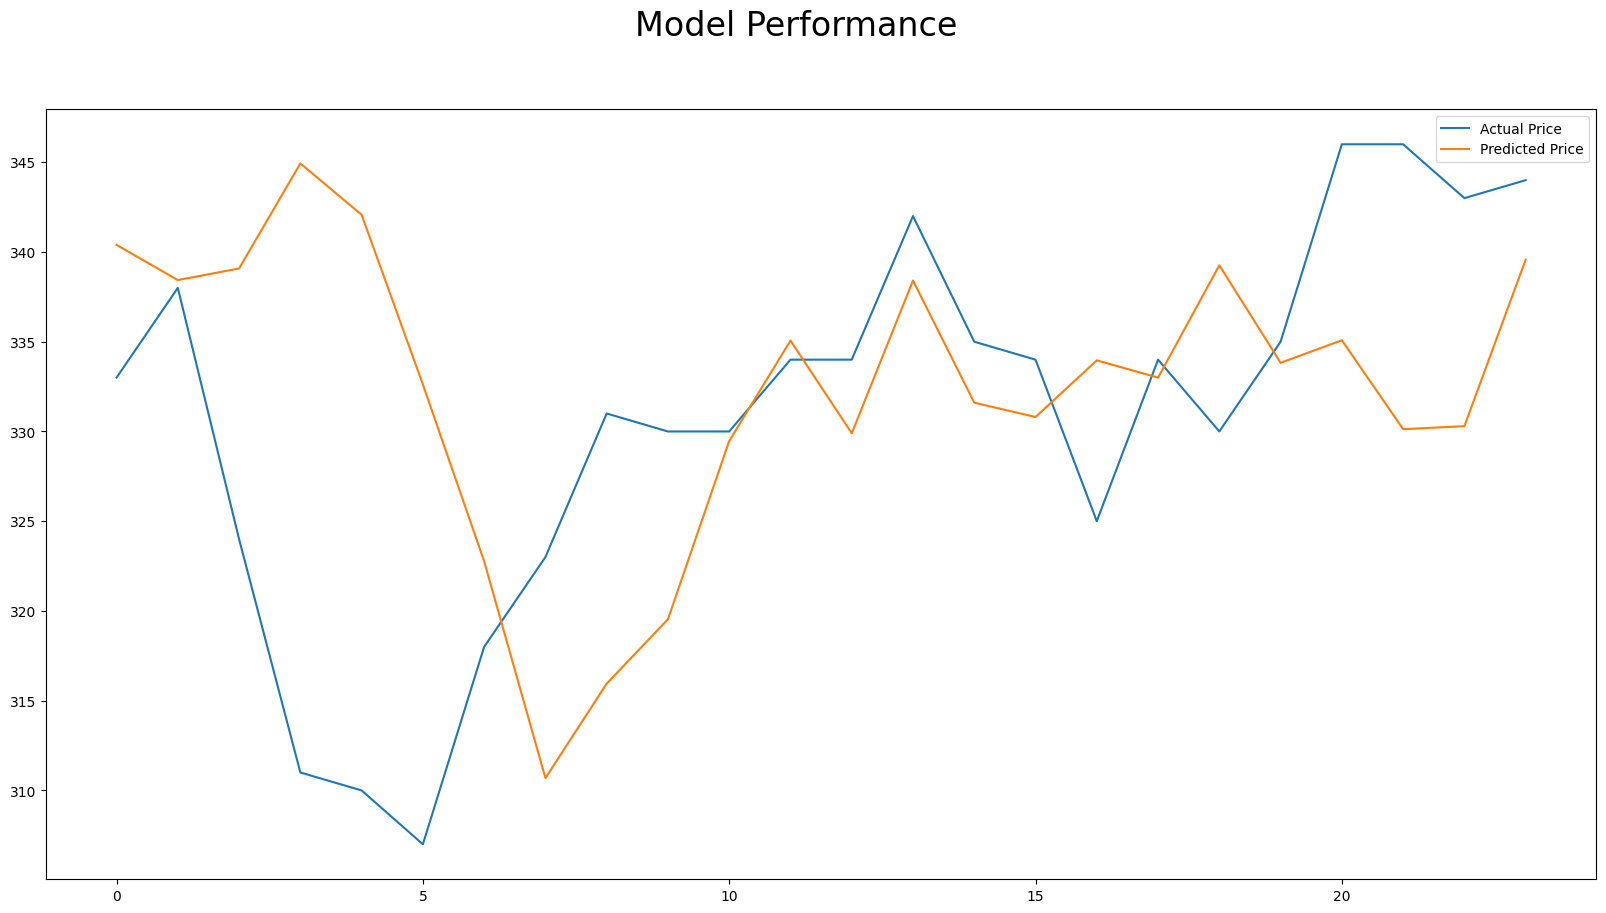

In [ ]:
# Getting original values from the file
orig_test_values = prices[['Price']].loc[total_size-len(predict_on_test):]
orig_test_values.reset_index(drop=True, inplace=True)

plt.figure(figsize=(20,10)).suptitle("Model Performance", fontsize=24)
plt.plot(orig_test_values, label="Actual Price")
plt.plot(predict_on_test, label="Predicted Price")
plt.legend()
plt.show()

# Predictions

In [ ]:
# previous 25 (lookback) prices
previous_prices = np.array([325,335,340,341,342,
                            325,329,316,312,317,
                            324,330,328,332,336,
                            341,339,335,328,328,
                            341,348,343,341,339])

# Standardize
previous_prices = scaler.transform(previous_prices.reshape(-1,1))

# Reshape
model_input = np.reshape(previous_prices,
                         (previous_prices.shape[1], 1, previous_prices.shape[0]))
print(model_input.shape)
# Predict!
prediction = price_model.predict(model_input)

# inverse tranform
norm_prediction = scaler.inverse_transform(prediction)

# Print the output
print("My prediction of the price of the next day is: ", norm_prediction)

(1, 1, 25)
1/1 [==============================] - 0s 56ms/step
My prediction of the price of the next day is:  [[334.739]]
